In [ ]:
import tensorflow as tf
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import string
import os
from PIL import Image
import glob
from pickle import dump, load
from time import time
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras import Input, layers
from keras import optimizers
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [ ]:
token = '/content/drive/MyDrive/TDL/captions.txt'

In [ ]:
captions = open(token, 'r').read().strip().split('\n')

In [ ]:
d = {}
for i, row in enumerate(captions):
    try:
      row = row.split(',')
      row[0] = row[0]
      if row[0] in d:
        d[row[0]].append(row[1])
      else:
          d[row[0]] = [row[1]]
    except:
      continue
print(d.keys())

dict_keys(['COCO_train2014_000000318556.jpg', 'COCO_train2014_000000116100.jpg', 'COCO_train2014_000000379340.jpg', 'COCO_train2014_000000134754.jpg', 'COCO_train2014_000000538480.jpg', 'COCO_train2014_000000476220.jpg', 'COCO_train2014_000000299675.jpg', 'COCO_train2014_000000032275.jpg', 'COCO_train2014_000000302443.jpg', 'COCO_train2014_000000025470.jpg', 'COCO_train2014_000000513461.jpg', 'COCO_train2014_000000018691.jpg', 'COCO_train2014_000000285579.jpg', 'COCO_train2014_000000266366.jpg', 'COCO_train2014_000000226658.jpg', 'COCO_train2014_000000124567.jpg', 'COCO_train2014_000000293605.jpg', 'COCO_train2014_000000321194.jpg', 'COCO_train2014_000000479495.jpg', 'COCO_train2014_000000539984.jpg', 'COCO_train2014_000000028231.jpg', 'COCO_train2014_000000350235.jpg', 'COCO_train2014_000000314265.jpg', 'COCO_train2014_000000389006.jpg', 'COCO_train2014_000000031813.jpg', 'COCO_train2014_000000465049.jpg', 'COCO_train2014_000000360334.jpg', 'COCO_train2014_000000524679.jpg', 'COCO_tra

In [ ]:

'''f1=open('/content/drive/MyDrive/TDL/tokens.txt','w')
for i in d:
  count=0
  for j in d[i]:
    string=i + '#'+str(count)+" "+j+'\n'.format(count)
    f1.write(string)
    count+=1
f1.close()'''


  


'f1=open(\'/content/drive/MyDrive/TDL/tokens.txt\',\'w\')\nfor i in d:\n  count=0\n  for j in d[i]:\n    string=i + \'#\'+str(count)+" "+j+\'\n\'.format(count)\n    f1.write(string)\n    count+=1\nf1.close()'

In [ ]:
'''f1=open('/content/drive/MyDrive/TDL/train.txt','w')
f2=open('/content/drive/MyDrive/TDL/test.txt','w')
n=0
for i in d.keys():
  if(n<40000):
    f1.write(i+'\n')
  elif(n<48000):
    f2.write(i+'\n')
  n+=1
f1.close()
f2.close()'''

"f1=open('/content/drive/MyDrive/TDL/train.txt','w')\nf2=open('/content/drive/MyDrive/TDL/test.txt','w')\nn=0\nfor i in d.keys():\n  if(n<40000):\n    f1.write(i+'\n')\n  elif(n<48000):\n    f2.write(i+'\n')\n  n+=1\nf1.close()\nf2.close()"

In [ ]:
'''f1=open('/content/drive/MyDrive/TDL/token.txt','w')
f2=open('/content/drive/MyDrive/TDL/tokens.txt','r')
for row in f2:
  try:
    name=row.split('#')
    n=name[1]
    f1.write(row)
  except:
    break
f1.close()
f2.close()'''

"f1=open('/content/drive/MyDrive/TDL/token.txt','w')\nf2=open('/content/drive/MyDrive/TDL/tokens.txt','r')\nfor row in f2:\n  try:\n    name=row.split('#')\n    n=name[1]\n    f1.write(row)\n  except:\n    break\nf1.close()\nf2.close()"

In [ ]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 
model = InceptionV3(weights='imagenet')

In [ ]:
from keras.models import Model
new_input = model.input
hidden_layer = model.layers[-2].output
model_new = Model(new_input, hidden_layer)

In [ ]:
def preprocess(image_path):
    # Convert all the images to size 299x299 as expected by the inception v3 model
    img = image.load_img(image_path, target_size=(299, 299))
    # Convert PIL image to numpy array of 3-dimensions
    x = image.img_to_array(img)
    # Add one more dimension
    x = np.expand_dims(x, axis=0)
    # preprocess the images using preprocess_input() from inception module
    x = preprocess_input(x)
    return x

In [ ]:
def encode(image):
    image = preprocess(image)
    temp_enc = model_new.predict(image)
    temp_enc = np.reshape(temp_enc, temp_enc.shape[1])
    return temp_enc

In [ ]:
def load_doc(filename):
    # open the file as read only
    file = open(filename, 'r')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text
 
filename = '/content/drive/MyDrive/TDL/token.txt'
# load descriptions
doc = load_doc(filename)

In [ ]:
def load_descriptions(doc):
    mapping = dict()
    # process lines
    for line in doc.split('\n'):
        # split line by white space
        tokens = line.split()
        if len(line) < 2:
            continue
        # take the first token as the image id, the rest as the description
        image_id, image_desc = tokens[0], tokens[1:]
        # extract filename from image id
        image_id = image_id.split('.')[0]
        # convert description tokens back to string
        image_desc = ' '.join(image_desc)
        # create the list if needed
        if image_id not in mapping:
            mapping[image_id] = list()
        # store description
        mapping[image_id].append(image_desc)
    return mapping
 
# parse descriptions
descriptions = load_descriptions(doc)
print('Loaded: %d ' % len(descriptions))

Loaded: 48000 


In [ ]:
list(descriptions.keys())[:5]

['COCO_train2014_000000318556',
 'COCO_train2014_000000116100',
 'COCO_train2014_000000379340',
 'COCO_train2014_000000134754',
 'COCO_train2014_000000538480']

In [ ]:
descriptions['COCO_train2014_000000318556']

['A very clean and well decorated empty bathroom',
 'A blue and white bathroom with butterfly themed wall tiles.',
 'A bathroom with a border of butterflies and blue paint on the walls above it.',
 'An angled view of a beautifully decorated bathroom.',
 'A clock that blends in with the wall hangs in a bathroom.']

In [ ]:
def clean_descriptions(descriptions):
    # prepare translation table for removing punctuation
    table = str.maketrans('', '', string.punctuation)
    for key, desc_list in descriptions.items():
        for i in range(len(desc_list)):
            desc = desc_list[i]
            # tokenize
            desc = desc.split()
            # convert to lower case
            desc = [word.lower() for word in desc]
            # remove punctuation from each token
            desc = [w.translate(table) for w in desc]
            # remove hanging 's' and 'a'
            desc = [word for word in desc if len(word)>1]
            # remove tokens with numbers in them
            desc = [word for word in desc if word.isalpha()]
            # store as string
            desc_list[i] =  ' '.join(desc)
 
# clean descriptions
clean_descriptions(descriptions)

In [ ]:
descriptions['COCO_train2014_000000318556']

['very clean and well decorated empty bathroom',
 'blue and white bathroom with butterfly themed wall tiles',
 'bathroom with border of butterflies and blue paint on the walls above it',
 'an angled view of beautifully decorated bathroom',
 'clock that blends in with the wall hangs in bathroom']

In [ ]:
# convert the loaded descriptions into a vocabulary of words
def to_vocabulary(descriptions):
    # build a list of all description strings
    all_desc = set()
    for key in descriptions.keys():
        [all_desc.update(d.split()) for d in descriptions[key]]
    return all_desc
 
# summarize vocabulary
vocabulary = to_vocabulary(descriptions)
print('Original Vocabulary Size: %d' % len(vocabulary))

Original Vocabulary Size: 18303


In [ ]:
def save_descriptions(descriptions, filename):
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + ' ' + desc)
    data = '\n'.join(lines)
    file = open(filename, 'w')
    file.write(data)
    file.close()
 
save_descriptions(descriptions, '/content/drive/MyDrive/TDL/descriptions.txt')

In [ ]:
def load_set(filename):
    doc = load_doc(filename)
    dataset = list()
    # process line by line
    for line in doc.split('\n'):
        # skip empty lines
        if len(line) < 1:
            continue
        # get the image identifier
        identifier = line.split('.')[0]
        dataset.append(identifier)
    return set(dataset)
 
# load training dataset (40K)
filename = '/content/drive/MyDrive/TDL/train.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))

Dataset: 40000


In [ ]:
image_folder = '/train2014/'
if not os.path.exists(os.path.abspath('.') + image_folder):
  image_zip = tf.keras.utils.get_file('train2014.zip',
                                      cache_subdir=os.path.abspath('.'),
                                      origin='http://images.cocodataset.org/zips/train2014.zip',
                                      extract=True)
  PATH = os.path.dirname(image_zip) + image_folder
  os.remove(image_zip)
else:
  PATH = os.path.abspath('.') + image_folder

In [ ]:
images = '/content/train2014/'
# Create a list of all image names in the directory
img = glob.glob(images + '*.jpg')

In [ ]:
img[:5]

['/content/train2014/COCO_train2014_000000355870.jpg',
 '/content/train2014/COCO_train2014_000000136015.jpg',
 '/content/train2014/COCO_train2014_000000061850.jpg',
 '/content/train2014/COCO_train2014_000000503715.jpg',
 '/content/train2014/COCO_train2014_000000327628.jpg']

In [ ]:
# Below file conatains the names of images to be used in train data
train_images_file = '/content/drive/MyDrive/TDL/train.txt'
# Read the train image names in a set
train_images = set(open(train_images_file, 'r').read().strip().split('\n'))
 
# Create a list of all the training images with their full path names
train_img = []
 
for i in img: # img is list of full path names of all images
    if i[len(images):] in train_images: # Check if the image belongs to training set
        train_img.append(i) # Add it to the list of train images

In [ ]:
# Below file conatains the names of images to be used in test data
test_images_file = '/content/drive/MyDrive/TDL/test.txt'
# Read the validation image names in a set# Read the test image names in a set
test_images = set(open(test_images_file, 'r').read().strip().split('\n'))
 
# Create a list of all the test images with their full path names
test_img = []
 
for i in img: # img is list of full path names of all images
    if i[len(images):] in test_images: # Check if the image belongs to test set
        test_img.append(i) # Add it to the list of test images

In [ ]:
def load_clean_descriptions(filename, dataset):
    # load document
    doc = load_doc(filename)
    descriptions = dict()
    for line in doc.split('\n'):
        # split line by white space
        tokens = line.split()
        # split id from description
        image_id, image_desc = tokens[0], tokens[1:]
        # skip images not in the set
        if image_id in dataset:
            # create list
            if image_id not in descriptions:
                descriptions[image_id] = list()
            # wrap description in tokens
            desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
            # store
            descriptions[image_id].append(desc)
    return descriptions
 
# descriptions
train_descriptions = load_clean_descriptions('/content/drive/MyDrive/TDL/descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))

Descriptions: train=39995


In [ ]:
def preprocess(image_path):
    # Convert all the images to size 299x299 as expected by the inception v3 model
    img = image.load_img(image_path, target_size=(299, 299))
    # Convert PIL image to numpy array of 3-dimensions
    x = image.img_to_array(img)
    # Add one more dimension
    x = np.expand_dims(x, axis=0)
    # preprocess the images using preprocess_input() from inception module
    x = preprocess_input(x)
    return x

In [ ]:
# Load the inception v3 model
model = InceptionV3(weights='imagenet')

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
'''with tf.device('/gpu:0'):
    config = tf.compat.v1.ConfigProto(gpu_options=
                                      tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=1)
                                      # device_count = {'GPU': 1}
                                      )
    config.gpu_options.allow_growth = True
    session = tf.compat.v1.Session(config=config)
    tf.compat.v1.keras.backend.set_session(session)
    tqdm().pandas()'''

"with tf.device('/gpu:0'):\n    config = tf.compat.v1.ConfigProto(gpu_options=\n                                      tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=1)\n                                      # device_count = {'GPU': 1}\n                                      )\n    config.gpu_options.allow_growth = True\n    session = tf.compat.v1.Session(config=config)\n    tf.compat.v1.keras.backend.set_session(session)\n    tqdm().pandas()"

In [ ]:
# Create a new model, by removing the last layer (output layer) from the inception v3
model_new = Model(model.input, model.layers[-2].output)

In [ ]:
# Function to encode a given image into a vector of size (2048, )
def encode(image):
    image = preprocess(image) # preprocess the image
    fea_vec = model_new.predict(image) # Get the encoding vector for the image
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1]) # reshape from (1, 2048) to (2048, )
    return fea_vec

In [ ]:
'''start = time()
encoding_train = {}
for img in tqdm(train_img):
    encoding_train[img[len(images):]] = encode(img)
print("Time taken in seconds =", time()-start)'''

'start = time()\nencoding_train = {}\nfor img in tqdm(train_img):\n    encoding_train[img[len(images):]] = encode(img)\nprint("Time taken in seconds =", time()-start)'

In [ ]:
# Save the bottleneck train features to disk
'''import pickle
with open("/content/drive/MyDrive/TDL/featuresTrain_Inception.p", "wb") as encoded_pickle:
    pickle.dump(encoding_train, encoded_pickle)'''

'import pickle\nwith open("/content/drive/MyDrive/TDL/featuresTrain_Inception.p", "wb") as encoded_pickle:\n    pickle.dump(encoding_train, encoded_pickle)'

In [ ]:
'''start = time()
encoding_test = {}
for img in tqdm(test_img):
    encoding_test[img[len(images):]] = encode(img)
print("Time taken in seconds =", time()-start)'''

'start = time()\nencoding_test = {}\nfor img in tqdm(test_img):\n    encoding_test[img[len(images):]] = encode(img)\nprint("Time taken in seconds =", time()-start)'

In [ ]:
'''with open("/content/drive/MyDrive/TDL/featuresTest_Inception.p", "wb") as encoded_pickle:
    pickle.dump(encoding_test, encoded_pickle)'''

'with open("/content/drive/MyDrive/TDL/featuresTest_Inception.p", "wb") as encoded_pickle:\n    pickle.dump(encoding_test, encoded_pickle)'

In [ ]:
train_features = load(open("/content/drive/MyDrive/TDL/featuresTrain_Inception.p", "rb"))
print('Photos: train=%d' % len(train_features))

Photos: train=39995


In [ ]:
# Create a list of all the training captions
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)
len(all_train_captions)

200072

In [ ]:
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d -> %d' % (len(word_counts), len(vocab)))

preprocessed words 16903 -> 4212


In [ ]:
ixtoword = {}
wordtoix = {}

ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

In [ ]:
vocab_size = len(ixtoword) + 1 # one for appended 0's
vocab_size

4213

In [ ]:
# convert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
    all_desc = list()
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

# calculate the length of the description with the most words
def max_length(descriptions):
    lines = to_lines(descriptions)
    return max(len(d.split()) for d in lines)

# determine the maximum sequence length
max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)

Description Length: 44


In [ ]:
# data generator, intended to be used in a call to model.fit_generator()
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            # retrieve the photo feature
            try:
              photo = train_features[key+'.jpg']
            except Exception as e:
              continue
            n+=1
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n==num_photos_per_batch:
                yield [array(X1), array(X2)], array(y)
                X1, X2, y = list(), list(), list()
                n=0

In [ ]:
'''!wget "http://nlp.stanford.edu/data/glove.6B.zip"
!unzip glove.6B.zip'''

'!wget "http://nlp.stanford.edu/data/glove.6B.zip"\n!unzip glove.6B.zip'

In [ ]:
glove_dir = ''
embeddings_index = {} # empty dictionary
f = open('/content/drive/MyDrive/TDL/glove.6B.200d.txt', encoding="utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [ ]:
embedding_dim = 200

# Get 200-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoix.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

In [ ]:
embedding_matrix.shape

(4213, 200)

In [ ]:
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
model = Model(inputs=[inputs1, inputs2], outputs=outputs)

In [ ]:
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 44)]         0           []                               
                                                                                                  
 input_9 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 44, 200)      842600      ['input_10[0][0]']               
                                                                                                  
 dropout_2 (Dropout)            (None, 2048)         0           ['input_9[0][0]']                
                                                                                            

In [ ]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [ ]:
epochs = 30
number_pics_per_bath = 32
steps = len(train_descriptions)//number_pics_per_bath

In [ ]:
'''for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save('model_' + str(i) + '.h5')'''

"for i in range(epochs):\n    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)\n    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)\n    model.save('model_' + str(i) + '.h5')"

In [ ]:
model.optimizer.lr = 0.0001
epochs = 10
number_pics_per_bath = 6
steps = len(train_descriptions)//number_pics_per_bath

In [ ]:
'''model.save_weights('model_30.h5')'''

"model.save_weights('model_30.h5')"

In [ ]:
from keras.models import load_model
model=load_model('/content/drive/MyDrive/TDL/model_9.h5')
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 44)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 44, 200)      842600      ['input_3[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['input_2[0][0]']                
                                                                                            

In [ ]:
model.load_weights('/content/drive/MyDrive/TDL/model_30.h5')

In [ ]:
images = ''

In [ ]:
with open("/content/drive/MyDrive/TDL/featuresTest_Inception.p", "rb") as encoded_pickle:
    encoding_test = load(encoded_pickle)

In [ ]:
with open("/content/drive/MyDrive/TDL/featuresTrain_Inception.p", "rb") as encoded_pickle:
    encoding_train = load(encoded_pickle)
print(encoding_train.keys())

dict_keys(['COCO_train2014_000000267028.jpg', 'COCO_train2014_000000267825.jpg', 'COCO_train2014_000000493883.jpg', 'COCO_train2014_000000401067.jpg', 'COCO_train2014_000000268317.jpg', 'COCO_train2014_000000393127.jpg', 'COCO_train2014_000000258727.jpg', 'COCO_train2014_000000226505.jpg', 'COCO_train2014_000000489585.jpg', 'COCO_train2014_000000053533.jpg', 'COCO_train2014_000000515304.jpg', 'COCO_train2014_000000281996.jpg', 'COCO_train2014_000000553502.jpg', 'COCO_train2014_000000193001.jpg', 'COCO_train2014_000000425988.jpg', 'COCO_train2014_000000291780.jpg', 'COCO_train2014_000000081749.jpg', 'COCO_train2014_000000172328.jpg', 'COCO_train2014_000000292351.jpg', 'COCO_train2014_000000157181.jpg', 'COCO_train2014_000000238001.jpg', 'COCO_train2014_000000337304.jpg', 'COCO_train2014_000000185579.jpg', 'COCO_train2014_000000148602.jpg', 'COCO_train2014_000000417036.jpg', 'COCO_train2014_000000485422.jpg', 'COCO_train2014_000000270898.jpg', 'COCO_train2014_000000451392.jpg', 'COCO_tra

In [ ]:
print(encoding_train['COCO_train2014_000000267028.jpg'])

[0.21688238 0.36774915 0.20843573 ... 0.08413336 0.31328917 0.39902163]


In [ ]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

In [ ]:
import os
for i in os.listdir('/content/train2014/'):
  if i in encoding_test.keys():
    print(i)
    break


COCO_train2014_000000503715.jpg


In [ ]:
# two references for one document
from nltk.translate.bleu_score import corpus_bleu
def get_result(pic):
  references=[]

  try:
    image = encoding_test[pic].reshape((1,2048))
    x=plt.imread('/content/train2014/'+pic)
    plt.imshow(x)
    plt.show()
    for i in d[pic]:
      i=i.strip('.')
      capt=i.split(" ")
      references.append(capt)
    reference=[references]
    predicted_capt=greedySearch(image)
    print("Predicted:", predicted_capt)
    candidates = predicted_capt.split(" ")
    candidate=[candidates]
    score = corpus_bleu(reference, candidate)
    print(score)
  except:
    try:
      image = encoding_train[pic].reshape((1,2048))
      x=plt.imread('/content/train2014/'+pic)
      plt.imshow(x)
      plt.show()
      for i in d[pic]:
        i=i.strip('.')
        capt=i.split(" ")
        references.append(capt)
      reference=[references]
      predicted_capt=greedySearch(image)
      print("Predicted:", predicted_capt)
      candidates = predicted_capt.split(" ")
      candidate=[candidates]
      score = corpus_bleu(reference, candidate)
      print(score)
    except:
      path=input()
      image_path=path+pic
      encoding_img={}
      encoding_img[pic]=encode(image_path)
      image = encoding_img[pic].reshape((1,2048))
      x=plt.imread(image_path)
      plt.imshow(x)
      plt.show()
      predicted_capt=greedySearch(image)
      print("Predicted:", predicted_capt)

      

In [ ]:
def get_res(pic,path):
  image_url = 'https://tensorflow.org/images/'+pic
  image_extension = image_url[-4:]
  image_path = tf.keras.utils.get_file('image'+image_extension, origin=image_url)
  encoding_img={}
  encoding_img[pic]=encode(image_path)
  image = encoding_img[pic].reshape((1,2048))
  x=plt.imread(image_path)
  plt.imshow(x)
  plt.show()
  predicted_capt=greedySearch(image)
  print("Predicted:", predicted_capt)


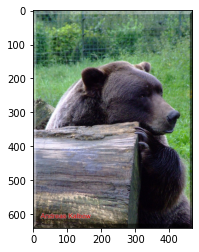

Predicted: bear is standing in the woods
0.5149052924789205


/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [ ]:
get_result('COCO_train2014_000000503715.jpg')

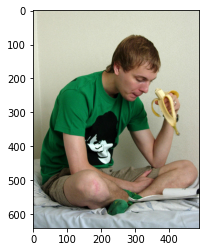

Predicted: man is sitting on the floor with his hands on his head
0.6529942057256104


/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [ ]:
get_result('COCO_train2014_000000369936.jpg')

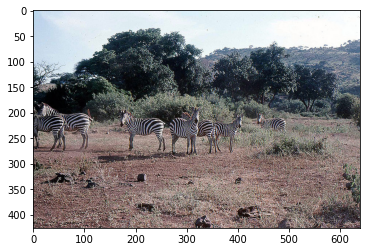

Predicted: zebras and zebras are standing in the grass
0.392814650900513


In [ ]:
get_result('COCO_train2014_000000382652.jpg')

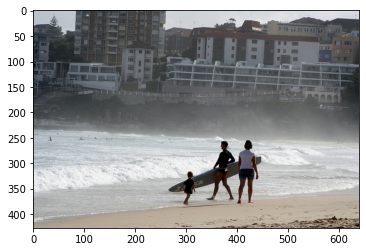

Predicted: man is riding horse on the beach
0.7536998328984836


/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [ ]:
get_result('COCO_train2014_000000513461.jpg')

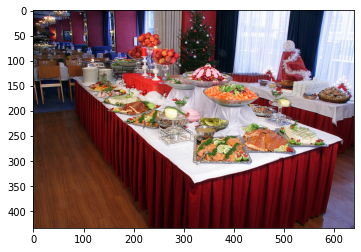

Predicted: two zebras are standing in the grass near trees
0.5773502691896257


/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [ ]:
get_result('COCO_train2014_000000543882.jpg')

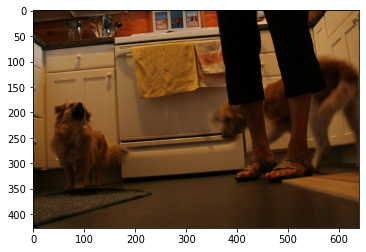

Predicted: dog is laying on the floor next to person
0.3303164318013807


/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [ ]:
get_result('COCO_train2014_000000161749.jpg')

73728/64400 [==================================] - 0s 1us/step


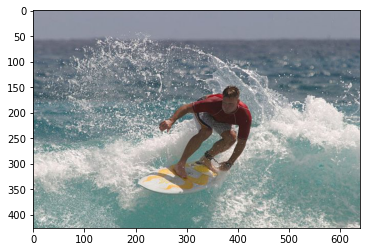

Predicted: man riding wave on the ocean while another man is surfing on the ocean


In [ ]:
get_res('surf.jpg','https://tensorflow.org/images/')

/content/drive/MyDrive/TDL/Test/Random/


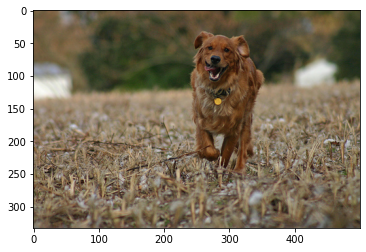

Predicted: two dogs are fighting in the grass


In [ ]:
get_result('69189650_6687da7280.jpg')